Auteurs: Guillaume PALUMBO et Laurie STEVENS <br>
Nom: Sod Shock Tube <br>
Date: 14 novembre 2016 <br>

Ce code a pour but de calculer l'évolution de la densité, de la vitesse et de la pression dans un tube de Sod. <br>
Il s'agit d'un tube au milieu duquel se trouve une cloison (en x=O m). Les pressions et densité sont différentes à gauche et à droite de cette cloison. La vitesse est quand à elle initialement nulle des deux côtés. <br>
A t=0 s, la cloison est instantanément retirée. L'air qui se déplace va provoquer une onde de choc lorsque la pression et la densité vont tenter de se rééquilibrer. <br>
Le but est d'étudier le déplacement de cette onde dans le tube à travers le temps.

Premièrement, rentrons toutes les valeurs de l'énoncé dont nous aurons besoin pour résoudre ce problème.

In [1]:
import numpy as np
import matplotlib.pyplot as pyp

INTERVAL = 81 #nx
SPACELAPS = 0.25 #dx in m
TIMELAPS = 0.0002 #dt in s
GAMMA = 1.4 #const depending on the gaz
DENSITY_L=1.0 #in kg/m³
VELOCITY_L=0.0 #in m/s
PRESSURE_L=100000.0 #in N/m²
DENSITY_R=0.125 #in kg/m³
VELOCITY_R=0.0 #in m/s
PRESSURE_R=10000.0 #in N/m²
LEFT=-10.0 #left end of the tube
RIGHT=10.0 #right end of the tube
TIME_MAX=0.01 #in s
SPACE=2.5 #in m

Implémentons maintenant une fonction qui permet d'initialiser les valeurs de la matrice U (qui représente les valeurs conservée pour l'équation d'Euler à chaque point de l'espace) à partir des conditions initiales.

In [2]:
def initial_u_line():
	first_line=np.zeros((INTERVAL,3))
	first_line[:(INTERVAL//2),0]=DENSITY_L
	first_line[:(INTERVAL//2),1]=DENSITY_L*VELOCITY_L
	first_line[:(INTERVAL//2),2]=(PRESSURE_L/(GAMMA-1))+((DENSITY_L*(VELOCITY_L**2))/2.0)
	first_line[(INTERVAL//2):,0]=DENSITY_R
	first_line[(INTERVAL//2):,1]=DENSITY_R*VELOCITY_R
	first_line[(INTERVAL//2):,2]=(PRESSURE_R/(GAMMA-1))+((DENSITY_R*(VELOCITY_R**2))/2.0)
	return first_line

Implémentons une fonction qui calcule les valeurs de la matrice F (qui représente le vecteur flux à chaque point de l'espace) à partir des valeurs de la matrice U.

In [3]:
def next_line_f(u_line):
	f_line=np.zeros((INTERVAL,3))
	f_line[:,0]=u_line[:,1]
	f_line[:,1]=((u_line[:,1]**2)/u_line[:,0])+((GAMMA-1)*(u_line[:,2]-((u_line[:,1]**2)/(u_line[:,0]*2.0))))
	f_line[:,2]=(u_line[:,2]+((GAMMA-1)*((u_line[:,2])-((u_line[:,1]**2)/(u_line[:,0]*2.0)))))*(u_line[:,1]/u_line[:,0])
	return f_line

Créons maintenant une fonction qui calcule la matrice U demi (qui servira dans à calculer les valeurs de F demi) à partir des valeurs de U et F.

In [4]:
def half_u(u_line,f_line):
	half_line_u=np.zeros((INTERVAL-1,3))
	for i in range(3):
		half_line_u[:,i]=((u_line[1:,i]+u_line[:-1,i])/2.0)-((TIMELAPS/(2.0*SPACELAPS))*(f_line[1:,i]-f_line[:-1,i]))
	return half_line_u

Définissons maintenant la fonction qui calcule F demi à partir des valeurs de U demi. La matrice F demi permettra d'utiliser la méthode de Richtmyer pour faire la boucle qui nous fera avancer dans le temps.

In [5]:
def half_f(half_line_u):
	half_line_f=np.zeros((INTERVAL-1,3))
	half_line_f[:,0]=half_line_u[:,1]
	half_line_f[:,1]=((half_line_u[:,1]**2)/half_line_u[:,0])+((GAMMA-1)*(half_line_u[:,2]-((1.0/2.0)*(((half_line_u[:,1]**2)/half_line_u[:,0])))))
	half_line_f[:,2]=(half_line_u[:,2]+((GAMMA-1)*((half_line_u[:,2])-((half_line_u[:,1]**2)/(half_line_u[:,0]*2.0)))))*(half_line_u[:,1]/half_line_u[:,0])
	return half_line_f

Finalement, implémentons la fonction qui permet de calculer la matrice U au temps suivant à partir de la matrice U actuelle et de la matrice F demi.

In [6]:
def next_line_u(u_line,half_line_f):
	following=u_line.copy()
	for i in range(3):
		following[1:-1,i]=u_line[1:-1,i]-((TIMELAPS/SPACELAPS)*(half_line_f[1:,i]-half_line_f[:-1,i]))
	return following

Nous pouvons enfin écrire la boucle qui nous permettra d'avancer dans le temps. <br>
Pour ce faire, initialisons tout d'abord les valeurs des matrices U,F,U demi, F demi. <br>
Ensuite, dans la boucle, calculons d'abord la nouvelle matrice U, et de celle-ci nous pouvons sortir les matrices F, U demi et F demi, et ainsi de suite la matrice U suivante et ainsi de suite jusqu'au temps souhaité.

In [7]:
u_line = initial_u_line()
f_line = next_line_f(u_line)
half_line_u = half_u(u_line,f_line)
half_line_f = half_f(half_line_u)
for i in range(int(TIME_MAX/TIMELAPS)):
	u_line=next_line_u(u_line,half_line_f)
	f_line=next_line_f(u_line)
	half_line_u=half_u(u_line,f_line)
	half_line_f=half_f(half_line_u) 

Il reste maintenant simplement à calculer les valeurs de la densité, de la vitesse et de la pression à partir des éléments de la dernière matrice U à avoir été calculée.

In [8]:
position = np.linspace(LEFT,RIGHT,INTERVAL)
index=int(-(LEFT-SPACE)/SPACELAPS)
density=u_line[:,0]
velocity=u_line[:,1]/u_line[:,0]
pressure=(GAMMA-1)*(u_line[:,2]-((u_line[:,1]**2)/(2.0*u_line[:,0])))
print("LA DENSITE EN x="+str(SPACE)+" m A t="+str(TIME_MAX)+" s EST : "+str(density[index])+" kg/m³")
print("LA VITESSE EN x="+str(SPACE)+" m A t="+str(TIME_MAX)+" s EST : "+str(velocity[index])+" m/s")
print("LA PRESSION EN x="+str(SPACE)+" m A t="+str(TIME_MAX)+" s EST : "+str(pressure[index])+" N/m²")

LA DENSITE EN x=2.5 m A t=0.01 s EST : 0.374691402648 kg/m³
LA VITESSE EN x=2.5 m A t=0.01 s EST : 292.611471527 m/s
LA PRESSION EN x=2.5 m A t=0.01 s EST : 30250.8901676 N/m²


Comme toujours, ces résultats ont été vérifiés et confirmés sur le site du MOOC.

En observant les graphiques ci-dessous, on se rend compte que leur forme générale correspond plus ou moins aux courbes attendues analytiquement. <br>
Les plateaux intermédiaires représentent l'onde de choc qui se déplace dans le tube. <br>
<br>
Au niveau des ressemblances avec le résultat analytique, on peut citer les plateaux. En effet, le graphique de la densité présente grosso modo deux plateaux intermédiaires entre le plateau de gauche et le plateau de droite (bien que mal définis, il reste possible de les deviner). Celui de la vitesse présente un seul plateau, le seul endroit où la vitesse n'est pas nulle. Le graphique de la pression présente un seul plateau intermédiaire entre le plateau de gauche et le plateau de droite. <br>
Par contre, pour les différences, on peut noter la mauvaise définition des plateaux cités ci-dessus. En effet, le début et la fin des plateaux sont systématiquement marqués par des pics soudains vers le haut ou vers le bas. De plus, comme dit ci-dessus, les deux plateaux du graphique de la densité sont mal définis et on les devine plus qu'on ne les voit. <br>

Graphique de la densité à t=0.01 s en fonction de la position:


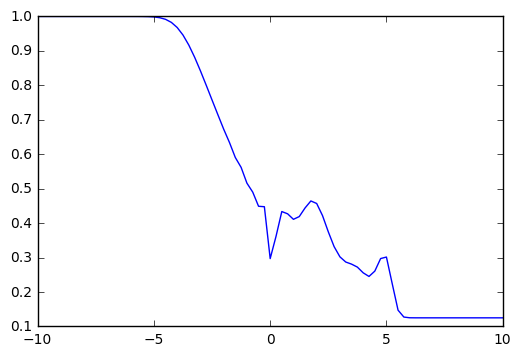

In [9]:
print("Graphique de la densité à t=0.01 s en fonction de la position:")
pyp.plot(position,density)
pyp.show()

Graphique de la vitesse à t=0.01 s en fonction de la position:


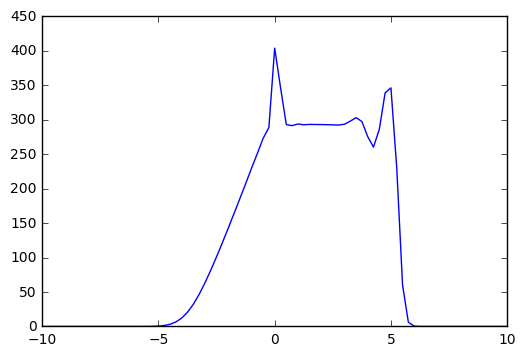

In [10]:
print("Graphique de la vitesse à t=0.01 s en fonction de la position:")
pyp.plot(position,velocity)
pyp.show() 

Graphique de la pression à t=0.01 s en fonction de la position:


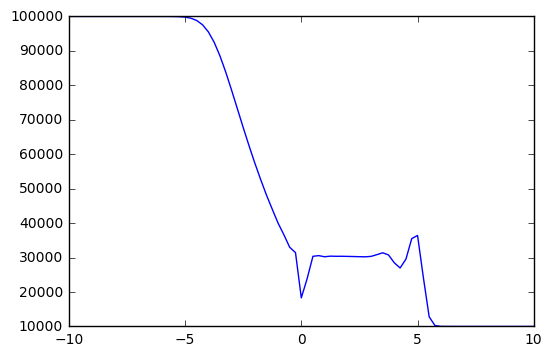

In [11]:
print("Graphique de la pression à t=0.01 s en fonction de la position:")
pyp.plot(position,pressure)
pyp.show() 

On peut ainsi conclure sur le fait que cette méthode est une relativement bonne approximation du résultat analytique, sauf si on se trouve à la limite entre les plateaux, là où les valeurs font des pics inattendus dans le modèle analytique.